# MC simulation: fit of the Rydberg constant

## 🧠 Theoretical Background: The Rydberg Constant

The **Rydberg constant** $R_H$ is a fundamental physical constant that describes the wavelengths of spectral lines in hydrogen and hydrogen-like atoms. It appears in the **Rydberg formula**, which gives the inverse of the wavelength $\lambda$ of emitted or absorbed light as an electron transitions between energy levels:

$
\frac{1}{\lambda} = R_H \left( \frac{1}{n_1^2} - \frac{1}{n_2^2} \right)
$

where:
- $ \lambda $ is the wavelength of the spectral line,
- $ n_1 $ and $ n_2 $ are the principal quantum numbers of the energy levels involved ($ n_2 > n_1 $),
- $ R_H $ is the Rydberg constant for hydrogen.

### Value and Importance
The currently accepted CODATA value is:

$
R_H \approx 1.0967757 \times 10^7 \, \text{m}^{-1}
$

This constant is central to atomic physics and quantum mechanics, as it encapsulates the binding energy structure of hydrogen.

In this notebook, we estimate $ R_H $ by inverting the Rydberg formula using measured wavelengths for the Balmer series (H-alpha and H-beta) and the parameters A and B previously obtained from diffraction measurements.


In [1]:
import ROOT
from math import *
import numpy as np
import time

Welcome to JupyROOT 6.28/04


In [2]:
#%jsroot on

## 📘 Part 1: Monte Carlo Estimation of A and B

This notebook computes the parameters **A** and **B** from measured diffraction angles of the H-alpha and H-beta lines. It uses Monte Carlo sampling to simulate measurement uncertainties on the angles and propagate them into the estimation of A and B.

- **Aims**
  - Measure the A and B parameters modeling the dependence of the refraction index on the wavelength, according to Cauchy relation
  $n(\lambda) = A + \frac{B}{\lambda^2} + O(\frac{1}{\lambda^3})$.

  For a given material, measuring the refraction index at two different wavelengths one can obtain the A and B coefficients.
  
  $A = n_2 - \lambda_1^2 \frac{n_1 - n_2}{\lambda_2^2 - \lambda_1^2}$

  $B = \frac{(n_1 - n_2) \lambda_1^2 \lambda_2^2}{\lambda_2^2 - \lambda_1^2}$

  The refracion index are obtained measuring the refraction angles at different wavelengths, as follows
  
  $n_i = n(\theta_i) = \frac{\sin\left(\frac{\theta_i - \theta_0 + \alpha}{2}\right)}{\sin\left(\frac{\alpha}{2}\right)}$

  for measured angles $\theta_1\equiv\theta(\lambda_1), \theta_2\equiv\theta(\lambda_2)$ and the prism angle $\alpha$.

  We also aim to propagate the uncertainties on the measured angles to these A and B parameters.

- **Inputs**:
  - Known wavelengths: $\lambda_a$ (656.3 nm, H $\alpha$), $\lambda_b$ (486.1 nm, H $\beta$)
  - Angular measurements: $\theta_1$, $\theta_2$, and their uncertainty

  - Grating spacing: d
  - Prism angle: $\alpha$

- **Outputs**:
  - Distributions of A and B from the Monte Carlo simulation
  - Mean values and standard deviations
  - Plots and ROOT file for further analysis

In [3]:
# Parameters and measurements
lambda1 = 579.1         # Wavelengths in nm
lambda2 = 404.7         # Wavelengths in nm
alpha = pi/3            # prism angle

# diffraction angles
th0 = 1.5701            
th1 = 2.6958
th2 = 2.7904

# error on the diffraction angles
eth = 0.0005

# statistical error on the diffraction angles
sigmath = eth/sqrt(3)

# Number of iterations in the Monte Carlo
nsteps = 20000  

In [4]:
# Functions
def GetAB(th0, th1, th2):
    delta1 = th1 - th0
    delta2 = th2 - th0
    n1 = sin((delta1 + alpha)/2)/sin(alpha/2)
    n2 = sin((delta2 + alpha)/2)/sin(alpha/2)
    A = n2 - lambda1**2 * (n1 - n2) / (lambda2**2 - lambda1**2)
    B = (n1 - n2) * lambda1**2 * lambda2**2 / (lambda2**2 - lambda1**2)
    v = np.array([A, B])
    return v

def getLambda(theta, th0, A, B):
    """
    Parameters
    ----------
    theta : float
        Diffraction angle in radians.
    th0 : float
        Zero order diffraction angle in radians.
    A : float
        Coefficient A from the dispersion relation.
    B : float
        Coefficient B from the dispersion relation.
    Returns
    -------
    wavelengths : float
        Calculated wavelength in nm.
    """
    n = sin((theta - th0 + alpha)/2)/sin(alpha/2)
    wavelengths = sqrt(B/(n - A))
    
    return wavelengths

In [5]:
# Main
[A, B] = GetAB(th0, th1, th2)
print('A = ', A)
print('B = ', B)


A =  1.7298151476003434
B =  13462.137256845486


In [6]:
# Calculate errors with variations in independent variables
e1 = GetAB(th0 + sigmath, th1, th2) - GetAB(th0, th1, th2)
e2 = GetAB(th0, th1 + sigmath, th2) - GetAB(th0, th1, th2)
e3 = GetAB(th0, th1, th2 + sigmath) - GetAB(th0, th1, th2)
eA = sqrt(e1[0]**2 + e2[0]**2 + e3[0]**2)
eB = sqrt(e1[1]**2 + e2[1]**2 + e3[1]**2)

In [7]:
print ('eA = ', eA)
print ('eB = ', eB)

eA =  0.00032241944739872875
eB =  58.27445369539057


In [ ]:
# Check the linearity of the function
e1 = GetAB(th0 - sigmath, th1, th2) - GetAB(th0, th1, th2)
e2 = GetAB(th0, th1 - sigmath, th2) - GetAB(th0, th1, th2)
e3 = GetAB(th0, th1, th2 - sigmath) - GetAB(th0, th1, th2)
eA = sqrt(e1[0]**2 + e2[0]**2 + e3[0]**2)
eB = sqrt(e1[1]**2 + e2[1]**2 + e3[1]**2)

In [8]:
# Generate MC data
rnd = ROOT.TRandom3()
rnd.SetSeed(157346789)

distr = 'gaus'
print("MonteCarlo based on Gaussian variables. To modify, go to line 77")

MonteCarlo based on Gaussian variables. To modify, go to line 77


In [9]:
# Create histograms
hA = ROOT.TH1D("A " + distr, "", 100, A - 4*eA, A + 4*eA)
hB = ROOT.TH1D("B " + distr, "", 100, B - 4*eB, B + 4*eB)
hCorr = ROOT.TH2D("A vs B " + distr, "", 100, A - 4*eA, A + 4*eA, 100, B - 4*eB, B + 4*eB)
hDelta = ROOT.TH2D("#delta_1 vs #delta_2 " + distr, "", 100, 0, 5, 100, 0, 5)
hN = ROOT.TH2D("n_1 vs n_2 " + distr, "", 100, 0, 5, 100, 0, 5)

In [10]:
# Loop for Monte Carlo iterations
for i in range(0, nsteps):
    if distr == "gaus":
        t0 = rnd.Gaus(th0, sigmath)
        t1 = rnd.Gaus(th1, sigmath)
        t2 = rnd.Gaus(th2, sigmath)
    elif distr == "unif":
        t0 = (2*eth*rnd.Rndm() - eth) + th0
        t1 = (2*eth*rnd.Rndm() - eth) + th1
        t2 = (2*eth*rnd.Rndm() - eth) + th2

    delta1 = t1 - t0
    delta2 = t2 - t0

    n1 = sin((delta1 + alpha)/2)/sin(alpha/2)
    n2 = sin((delta2 + alpha)/2)/sin(alpha/2)

    [A, B] = GetAB(t0, t1, t2)
    hA.Fill(A)
    hB.Fill(B)
    hCorr.Fill(A, B)
    hDelta.Fill(delta1, delta2)
    hN.Fill(n1, n2)

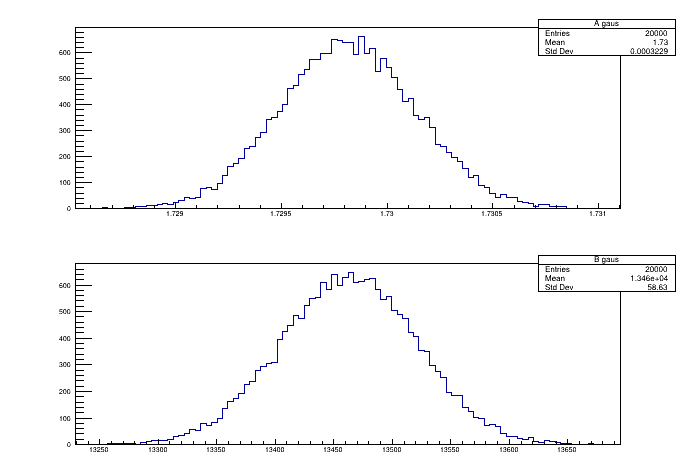

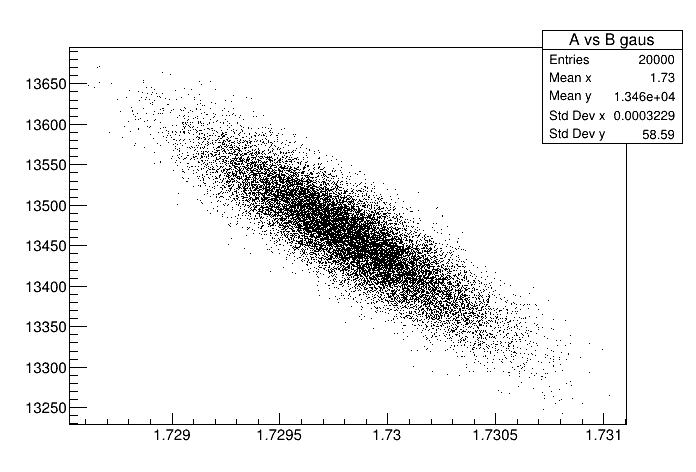

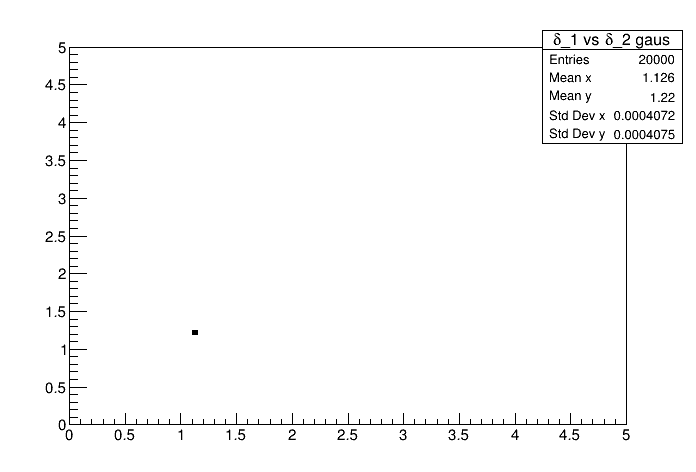

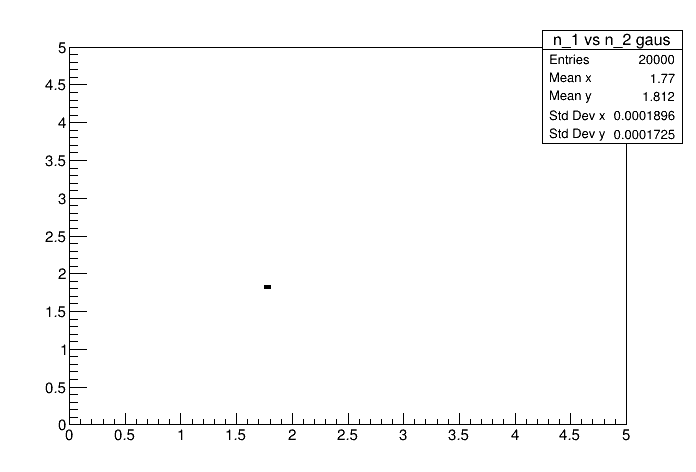

In [11]:
## draw the plots
c1=ROOT.TCanvas()
c1.Divide(1,2)
c1.cd(1)
hA.Draw()
c1.cd(2)
hB.Draw()
c1.Draw()

c2=ROOT.TCanvas()
hCorr.Draw()
c2.Draw()
c3=ROOT.TCanvas()
hDelta.Draw()
c3.Draw()
c4=ROOT.TCanvas()
hN.Draw()
c4.Draw()

In [12]:
# Calculating values from histograms
meanA = hA.GetMean()
sigmaA = hA.GetRMS()
meanB = hB.GetMean()
sigmaB = hB.GetRMS()
corrAB = hCorr.GetCorrelationFactor()
corrDelta = hDelta.GetCorrelationFactor()
corrN = hN.GetCorrelationFactor()

In [13]:
print("\n")
print("Values obtained from Monte Carlo")
print("A = ", meanA, "+/-", sigmaA)
print("B = ", meanB, "+/-", sigmaB)
print("Correlation coefficient AB = ", corrAB)
print("\n")
print("Correlation coefficient on delta = ", corrDelta)
print("Correlation coefficient on n = ", corrN)



Values obtained from Monte Carlo
A =  1.7298159702034892 +/- 0.0003229463950358803
B =  13462.46224313792 +/- 58.63102610336444
Correlation coefficient AB =  -0.8764877608314606


Correlation coefficient on delta =  0.4916540947055525
Correlation coefficient on n =  0.4916553092565021


### Part 2: measure wavelengths using the calibrated A and B

For different wavelengths, fit the formula

$
\frac{1}{\lambda} = R_H \left( \frac{1}{n_1^2} - \frac{1}{n_2^2} \right)
$

to obtain $R_H$.

In [14]:
## Measured angles
theta = np.array([2.6773, 2.7324, 2.7651, 2.7846])  # Red, green, blue, violet

wavelengths = np.array([])  # Wavelengths

## Get the measured wavelengths from the angles
for i in range(0, 4):
    wavelengths = np.append(wavelengths, getLambda(theta[i], th0, meanA, meanB))  # Wavelengths

print("Wavelengths \n", wavelengths)

# Prepare graph creation for the fit for R_H
j = 2  # Energy level 2 of hydrogen, letter n already occupied
xaxis = np.array([])
for i in range(3, 7):
    #xaxis = np.append(xaxis, 1./(j**2) - 1./(i**2))  # Array with x coordinates
    xaxis = np.append(xaxis,i)

Wavelengths 
 [654.24015284 486.4709621  434.40204007 410.90916514]


In [15]:
can = ROOT.TCanvas()
can.Divide(2, 2)

# Consider only errors on the angles th_i
can.cd(1)
can.SetTitle("Rydberg Constant")
gr = ROOT.TGraphErrors()
gr.SetTitle("Errors on the angles")
#gr.GetXaxis().SetTitle("#frac{1}{n^{2}} - #frac{1}{m^{2}}")
#gr.GetYaxis().SetTitle("1/#lambda")

gr.GetXaxis().SetTitle("m")
gr.GetYaxis().SetTitle("#lambda")

In [16]:
sigmaY = np.array([])  # Array with errors on y
for i in range(0, 4):

    # Calculate the error on the wavelength
    sigmaY = np.append(sigmaY, getLambda(theta[i] + sigmath, th0, meanA, meanB) - wavelengths[i])

    # Set the point in the graph
    gr.SetPoint(i, xaxis[i], wavelengths[i])
    gr.SetPointError(i, 0, sigmaY[i])

gr.Draw("AP")

# Define function for the Rydberg constant
f = ROOT.TF1("f","1/([1]*(1/[0]^2-1/x^2))",0,10)

# Set parameters for the fit function
f.SetParName(1,"Rh")    # Rydberg constant
f.SetParName(0,"n")     # Principal quantum number
f.FixParameter(0,2)     # Fix n to 2 for the second energy level
f.SetParameter(1,0.01)  # Initial guess for Rydberg constant

# Fit the graph
gr.Fit("f")

# get the fit parameters and their errors
Rh_angoli = f.GetParameter(1)
sigmaRh_angoli = f.GetParError(1)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      4.43372
NDf                       =            3
Edm                       =  1.69453e-08
NCalls                    =           24
n                         =            2                      	 (fixed)
Rh                        =    0.0109786   +/-   1.32007e-05 


In [17]:
# Errors on A, B, and th0
grA = ROOT.TGraphErrors()
grB = ROOT.TGraphErrors()
grTh0 = ROOT.TGraphErrors()

# loop on the wavelengths
for i in range(0, 4):

    # Calculate the errors on A, B, and th0
    sigmaYA = getLambda(theta[i], th0, meanA + sigmaA, meanB) - wavelengths[i]
    sigmaYB = getLambda(theta[i], th0, meanA, meanB + sigmaB) - wavelengths[i]
    sigmaYth0 = getLambda(theta[i], th0 + sigmath, meanA, meanB) - wavelengths[i]

    # Fill the graphs with the errors
    grA.SetPoint(i, xaxis[i], getLambda(theta[i], th0, meanA + sigmaA, meanB))
    grA.SetPointError(i, 0, sigmaYA)
    grB.SetPoint(i, xaxis[i], getLambda(theta[i], th0, meanA, meanB + sigmaB))
    grB.SetPointError(i, 0, sigmaYB)
    grTh0.SetPoint(i, xaxis[i], getLambda(theta[i], th0 + sigmath, meanA, meanB))
    grTh0.SetPointError(i, 0, sigmaYth0)

 FCN=0.13331 FROM MIGRAD    STATUS=CONVERGED      15 CALLS          16 TOTAL
                     EDM=4.88545e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  n            2.00000e+00     fixed    
   2  Rh           1.09336e-02   1.41201e-05   7.33860e-09   7.00053e+01
 FCN=2.98323 FROM MIGRAD    STATUS=CONVERGED      15 CALLS          16 TOTAL
                     EDM=3.98196e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  n            2.00000e+00     fixed    
   2  Rh           1.09467e-02   1.18798e-05   1.15769e-08  -2.37549e+00
 FCN=2.47757 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=3.4775e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT 

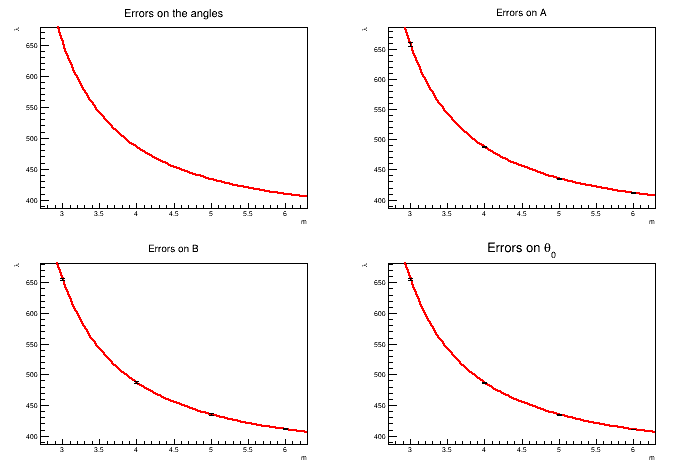

In [18]:
## Draw the graphs with errors

# errors on A
can.cd(2)
grA.SetTitle("Errors on A")
grA.GetXaxis().SetTitle("m")
grA.GetYaxis().SetTitle("#lambda")
grA.Draw("AP")
grA.Fit("f")
RhA = f.GetParameter(1)
sigmaRh_A = f.GetParError(1)

## errors on B
can.cd(3)
grB.SetTitle("Errors on B")
grB.GetXaxis().SetTitle("m")
grB.GetYaxis().SetTitle("#lambda")
grB.Draw("AP")
grB.Fit("f")
RhB = f.GetParameter(1)
sigmaRh_B = f.GetParError(1)

# errors on th0
can.cd(4)
grTh0.SetTitle("Errors on #theta_{0}")
grTh0.GetXaxis().SetTitle("m")
grTh0.GetYaxis().SetTitle("#lambda")
grTh0.Draw("AP")

# Fit the graph
grTh0.Fit("f")

can.Draw()

# Get the Rydberg constant from the fit
RhTh0 = f.GetParameter(1)
sigmaRh_th0 = f.GetParError(1)


# Calculate the total error on the Rydberg constant


In [19]:
# Calculate the total error on the Rydberg constant
sigmaRh_AB=sqrt((Rh_angoli-RhA)**2+(Rh_angoli-RhB)**2+2*corrAB*(RhA-Rh_angoli)*(RhB-Rh_angoli))
sigmaRh_Tot=sqrt(sigmaRh_angoli**2+sigmaRh_AB**2+(RhTh0-Rh_angoli)**2)

print("\n")
print("------------------------")
print("\n")

print("Contribution from AB = ", sigmaRh_AB)
print("Contribution from th0 = ", abs(RhTh0 - Rh_angoli) )
print("Contribution from th_i = ", sigmaRh_angoli )

print("Best estimate for Rydberg Constant = ", Rh_angoli, "+/-", sigmaRh_Tot )



------------------------


Contribution from AB =  2.296074596976457e-05
Contribution from th0 =  2.9085832108012577e-05
Contribution from th_i=  1.3200721620426356e-05
Best estimate for Rydberg Constant =  0.010978643672407808 +/- 3.933752071754837e-05
